In [1]:
import socket
import spynnaker8 as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
import pdb
import numpy as np
from numpy import genfromtxt
from spinnorse_tools import fetch_files, plot_iho
import os
import time

Detected PyNN version 0.9.4 and Neo version 0.6.1


In [2]:
dt = 1           # (ms) simulation timestep

cell_params = {'tau_m': 20.0,
               'tau_syn_E': 5.0,
               'tau_syn_I': 5.0,
               'v_rest': -65.0,
               'v_reset': -65.0,
               'v_thresh': -50.0,
               'tau_refrac': 0.0, # 0.1 originally
               'cm': 1,
               'i_offset': 0.0
               }

w = 1

In [3]:
#SpiNNaker Setup
delay = 2*dt
nb_steps = 200
node_id = p.setup(timestep=dt, min_delay=delay, max_delay=delay)     
p.set_number_of_neurons_per_core(p.IF_curr_exp, 10) #  100 neurons per core

nb_hl = 1
ratio = 1
nb_nol = 1
nb_nhl = nb_nol*(ratio**(nb_hl))
nb_nil = nb_nol*(ratio**(nb_hl+1))

# Fetch available trains of spikes in path
path = "summary/common/"
files = fetch_files(path)

# Stack Spike Trains
n = len(files)
spike_trains = np.zeros((nb_steps,n))
for i in range(n):
    try:
        spike_trains[:,i] = genfromtxt(files[i], delimiter=',')
    except:
        print("spikes_%02d.csv not available " % (i+1))
        
#i_spikes = np.random.randint(2, size=(nb_steps,1))
spike_trains[:,0] = genfromtxt("summary/common/spikes_12.csv", delimiter=',')

# spike_trains = np.zeros((nb_steps,n))
# spike_trains[10,0] = 1


# Get input data
i_spikes = spike_trains[:,0]
i_indexes = np.asarray(np.where(i_spikes>0))



# Create Populations
print("Creating cell populations in node %s ..." % node_id)
celltype = p.IF_curr_exp

fcnn_i = p.Population(nb_nil,p.SpikeSourceArray(spike_times=(i_indexes)))
fcnn_h = p.Population(nb_nhl, celltype(**cell_params), label="fcnn_h")
fcnn_o = p.Population(nb_nol, celltype(**cell_params), label="fcnn_o")



# Setup Connectivity
print("Connecting populations  in node %s ..." % node_id)
cell_conn = p.AllToAllConnector()
connections = {'il_hl': p.Projection(fcnn_i, fcnn_h, cell_conn,
                        receptor_type='excitatory',
                        synapse_type=p.StaticSynapse(weight=w, delay=0)),
               'hl_ol': p.Projection(fcnn_h, fcnn_o, cell_conn,
                        receptor_type='excitatory',
                        synapse_type=p.StaticSynapse(weight=w, delay=0))}

# Record Voltages and Spikes
print("Setting up recording in node %s ..." % node_id)
fcnn_i.record(["spikes"])
fcnn_h.record(["v","spikes"])
fcnn_o.record(["v","spikes"])


2020-12-23 23:26:57 INFO: Read cfg files: /home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/jprb/.spynnaker.cfg
2020-12-23 23:26:57 INFO: Will search these locations for binaries: /home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries


['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']


2020-12-23 23:26:57 WARNING: /home/jprb/SpiNNorse/reports has 27 old reports that have not been closed
2020-12-23 23:26:57 WARNING: /home/jprb/SpiNNorse/application_generated_data_files has 27 old reports that have not been closed
2020-12-23 23:26:57 INFO: Setting time scale factor to 1.
2020-12-23 23:26:57 INFO: Setting machine time step to 1000 micro-seconds.


Creating cell populations in node 0 ...
Connecting populations  in node 0 ...
Setting up recording in node 0 ...


In [4]:

# Start Simulation
print("%d Running simulation..." % node_id)
p.run(nb_steps)

# Get recorded data
z_il = fcnn_i.get_data("spikes")
v_hl = fcnn_h.get_data("v")
z_hl = fcnn_h.get_data("spikes")
v_ol = fcnn_o.get_data("v")
z_ol = fcnn_o.get_data("spikes")

# End Simulation

p.end()

2020-12-23 23:26:57 INFO: Simulating for 200 1.0ms timesteps using a hardware timestep of 1000us
2020-12-23 23:26:57 INFO: Starting execution process
2020-12-23 23:26:57 INFO: Creating transceiver for 192.168.240.1
2020-12-23 23:26:57 INFO: Working out if machine is booted
2020-12-23 23:26:57 INFO: Found board with version [Version: SC&MP 3.2.5 at SpiNNaker:0:0:0 (built Thu Aug  1 10:15:06 2019)]
2020-12-23 23:26:57 INFO: Machine communication successful
2020-12-23 23:26:57 INFO: Detected a machine on IP address 192.168.240.1 which has 858 cores and 120.0 links
2020-12-23 23:26:57 INFO: Time 0:00:00.020661 taken by MachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2020-12-23 23:26:57 INFO: Time 0:00:00.037353 taken by PreAllocateResourcesForExtraMonitorSupport
2020-12-23 23:26:57 INFO: Time 0:00:00.000671 taken by NetworkSpecificationReport
Partitioning graph vertices
|0%                          

0 Running simulation...


2020-12-23 23:26:57 INFO: Time 0:00:00.022150 taken by PartitionAndPlacePartitioner
Generating partitioner report
|0%                          50%                         100%|
2020-12-23 23:26:57 INFO: Time 0:00:00.011137 taken by PartitionerReport
Allocating virtual identifiers
|0%                          50%                         100%|
2020-12-23 23:26:57 INFO: Time 0:00:00.031216 taken by MallocBasedChipIDAllocator
Inserting extra monitors into graphs
|0%                          50%                         100%|
2020-12-23 23:26:57 INFO: Time 0:00:00.042538 taken by InsertExtraMonitorVerticesToGraphs
Writing the board chip report
|0%                          50%                         100%|
2020-12-23 23:26:58 INFO: Time 0:00:00.009514 taken by BoardChipReport
Filtering edges
|0%                          50%                         100%|
2020-12-23 23:26:58 INFO: Time 0:00:00.046564 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%               

2020-12-23 23:27:13 INFO: Time 0:00:00.038694 taken by FixedRouteFromMachineReport
Loading executables onto the machine
|0%                          50%                         100%|
2020-12-23 23:27:19 INFO: Time 0:00:06.761503 taken by LoadApplicationExecutableImages
Reading Routing Tables from Machine
|0%                          50%                         100%|
2020-12-23 23:27:19 INFO: Time 0:00:00.011831 taken by RoutingTableFromMachineReport
Generating compressed router table report
|0%                          50%                         100%|
2020-12-23 23:27:19 INFO: Time 0:00:00.004460 taken by compressedRoutingTableReports
Generating comparison of router table report
|0%                          50%                         100%|
2020-12-23 23:27:19 INFO: Time 0:00:00.008894 taken by comparisonOfRoutingTablesReport
2020-12-23 23:27:19 INFO: Running for 1 steps for a total of 200.0ms
2020-12-23 23:27:19 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                      

In [5]:
time.sleep(20)

i_indexes = np.asarray(z_il.segments[0].spiketrains[0])
i_spikes = np.zeros((nb_steps,nb_nil))
for i in i_indexes.astype(int):
    i_spikes[i,:] = 1


v_hl = np.array(v_hl.segments[0].filter(name="v")[0]).reshape((nb_steps,nb_nhl))
o_indexes_hl = np.asarray(z_hl.segments[0].spiketrains[0])
o_spikes_hl = np.zeros((nb_steps,nb_nhl))
for i in o_indexes_hl.astype(int):
    o_spikes_hl[i,:] = 1

v_ol = np.array(v_ol.segments[0].filter(name="v")[0]).reshape((nb_steps,nb_nol))
o_indexes_ol = np.asarray(z_ol.segments[0].spiketrains[0])
o_spikes_ol = np.zeros((nb_steps,nb_nol))
for i in o_indexes_ol.astype(int):
    o_spikes_ol[i,:] = 1


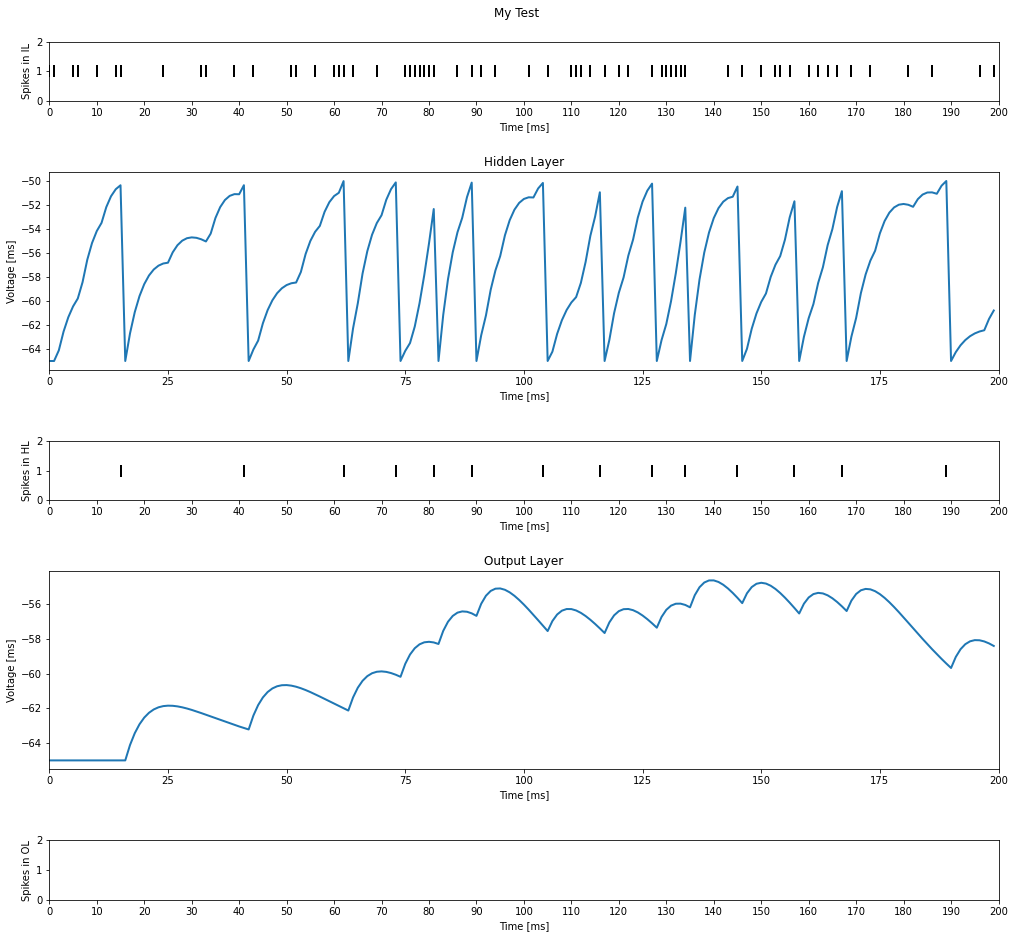

In [6]:
# Plot Stuff
sfn = "My Test"
plot_iho(i_spikes, o_spikes_hl, v_hl, o_spikes_ol, v_ol, sfn, nb_steps, ratio)

In [7]:
max(v_hl[0:nb_steps,:])

array([-50.01101685])

In [8]:
max(v_ol[0:nb_steps,:])

array([-54.63861084])